### QAOA with real data

QTFT Team, 23/05/2020
- No divide and conquer yet
- Communities are breakdown into <10 assets with greedy modularity and Louvian algorithms
- QAOA is simulated using tensor network and w-state anzat
- Linear relaxation is used as a classical benchmark

In [2]:
import numpy as np
from qaoa_tn import Relaxation, Exact
from qaoa_dc import QAOA_DC
from qaoa_dc import LGP, QSR, get_bit, get_dict, _getCost
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import community
import random
#import func

Load data

In [3]:
As = sparse.load_npz('data/a_matrix.npz')
Qs = sparse.load_npz('data/q_matrix.npz')

Create subgroup

frozenset({5527, 7875, 8744, 905, 2135, 8951, 1118, 6487})
Size of the selected group: 8


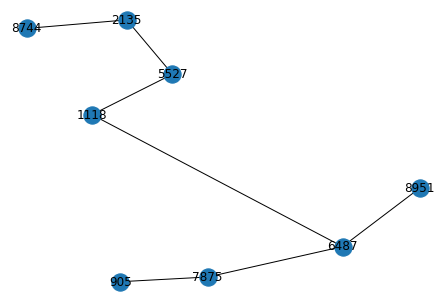

Subgroup size distribution according to Louvian algorithm 


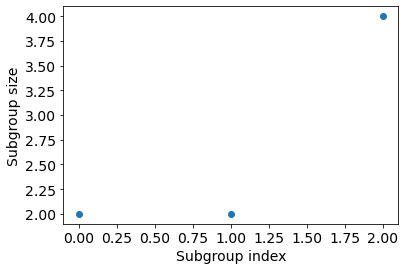

Size of the selected subgroup: 4


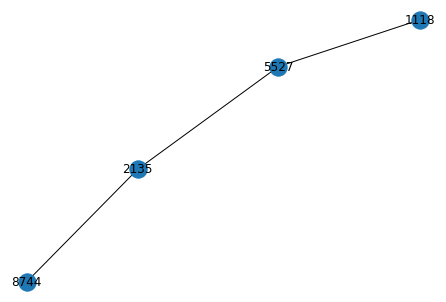

In [21]:
# Create cgroups using greedy modularity communities
As_nx = nx.from_scipy_sparse_matrix(As)
groups = nx.algorithms.community.modularity_max.greedy_modularity_communities(As_nx)

# Randomly select a group
idx = random.choice(groups)
while len(idx) > 10:
    idx = random.choice(groups)
G = As_nx.subgraph(idx)
asset_idx = G.nodes()

# Create subgroups using Louvain algorithm
subgroups = community.best_partition(G)

# Randomly select a subgroup
keys = np.array(list(subgroups.keys()))
vals = np.array(list(subgroups.values()))
asset_idx = keys[np.where(vals==np.random.randint(max(vals)))[0]]
g = As_nx.subgraph(asset_idx)

"""
print("Group size distribution according to greedy modularity algorithm")
plt.figure()
plt.plot(np.sort([len(x) for x in groups]),'o')
plt.xlabel('Group index',fontsize=14)
plt.ylabel('Group size',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
"""

print("Size of the selected group: %d"%len(G))
plt.figure()
nx.draw(G, with_labels = True)
plt.show()


print("Subgroup size distribution according to Louvian algorithm ")
plt.figure()
plt.plot(np.sort(np.unique(vals,return_counts=True)[1]),'o')
plt.xlabel('Subgroup index',fontsize=14)
plt.ylabel('Subgroup size',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


print("Size of the selected subgroup: %d"%len(g))
plt.figure()
nx.draw(g, with_labels = True)
plt.show()


Divide-and-Conquer QAOA with shared nearest neighbor method.
Dividing the big community by louvian algorithm does not provide subgroups containing shared nodes. Thus we have to manually add the nearest node, which is not in the same subgroup, as a shared node and vice versa.

Define list of subgroups to be solved by QAOA.

In [293]:
subgroups_list = []

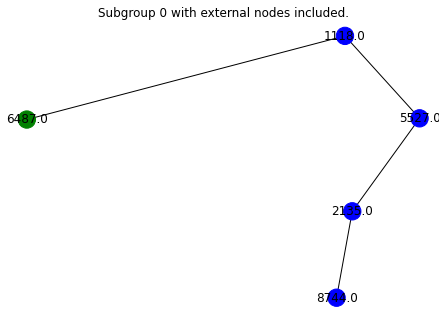

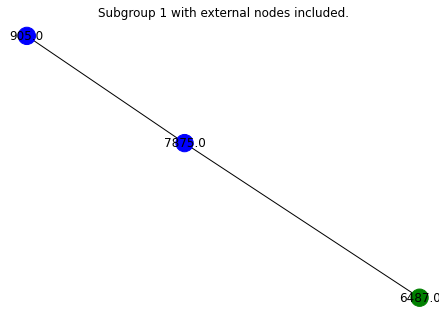

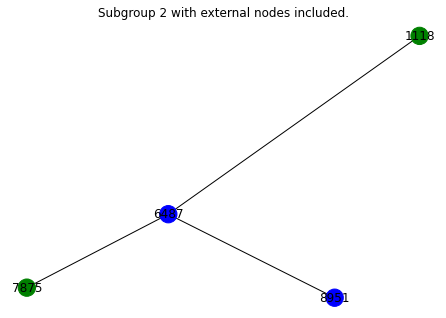

In [294]:
#Loop though each subgroups to get new subgroup including nearest neigher.
#Original subgroup.
for subgroup in np.unique(vals):
    asset_idx = keys[np.where(vals==subgroup)[0]]
    asset_idx_old = asset_idx #For coloring
    g = As_nx.subgraph(asset_idx)

#Check each assets for any external edge.
#Add an indice of external asset into asset_idx and recreate new subgroup.
    edges_ext = [] #Need this line to prevent memory bug.
    for asset in g.nodes:
        if len(G.edges(asset)) != len(g.edges(asset)):
            edges_ext = [v for (u,v) in list(G.edges(asset)) if (u,v) not in list(g.edges(asset)) ]
        asset_idx = np.append(asset_idx, edges_ext)
    asset_idx = np.unique(asset_idx) #Ensure no duplicated asset index.
    g = As_nx.subgraph(asset_idx)
    
    nodes_ext = [ext for ext in asset_idx if ext not in asset_idx_old]
    colors = ['g' if node in nodes_ext else 'b' for node in g.nodes() ]

    plt.figure()
    nx.draw(g, with_labels = True, node_color=colors)
    plt.title("Subgroup "+str(subgroup)+" with external nodes included.")
    plt.show()

    subgroups_list.append(asset_idx)

Solve each subgroups with QAOA.
QAOA needs only asset_idx, no graph g needed.

In [295]:
subgroups_list

[array([1118., 2135., 5527., 6487., 8744.]),
 array([ 905., 6487., 7875.]),
 array([1118, 6487, 7875, 8951])]

Create input's parameters

In [5]:
"""
# Number of assets
N = len(asset_idx)
# Number of actions
M = 7
# Selected actions
action_idx = np.arange(M)
# Q values
Q = np.array(Qs[asset_idx][:,action_idx].todense()) / 8000
# A values
A = np.array(As[asset_idx][:,asset_idx].todense())
# epsilon
e = 1
# Number of cycles, the circuit layer "p"
cycles = 4
"""

In [300]:
numCandidates = 20
# Number of actions
M = 7
# Selected actions
action_idx = np.arange(M)
# epsilon
e = 1
# Number of cycles, the circuit layer "p"
cycles = 4

cnt_list = []
for count, idx_list in enumerate(subgroups_list):
    # Number of assets
    N = len(idx_list)
    # Q values
    Q = np.array(Qs[idx_list][:,action_idx].todense()) / 8000
    # A values
    A = np.array(As[idx_list][:,asset_idx].todense())
    qaoa = QAOA_DC(N, M, Q, A, e, cycles)
    qaoa.optimized(maxiter=20,method='BFGS')
    cnt_list.append(qaoa.getCandidate(numCandidates))

         Current function value: -22.977416
         Iterations: 20
         Function evaluations: 252
         Gradient evaluations: 28
         Current function value: -15.270325
         Iterations: 20
         Function evaluations: 288
         Gradient evaluations: 32
         Current function value: -19.399589
         Iterations: 20
         Function evaluations: 252
         Gradient evaluations: 28


In [302]:
cnt_list[0]

{'56100': (0.002573638964330164-0.07123533373713484j),
 '56600': (0.04713968993282617+0.054853894776126004j),
 '16203': (-0.01668239159301115+0.070738985332362j),
 '16400': (0.059407082497574926-0.04214470242626052j),
 '10200': (-0.05693011003291786+0.04621555948971569j),
 '06200': (0.07104664386269283+0.018816741183936937j),
 '11201': (0.06138718491877357-0.04112804924145466j),
 '14200': (0.07108879808713228-0.02465575416416301j),
 '12200': (-0.04458250207067767-0.0692280524504624j),
 '56201': (-0.04562733823197827+0.06921774453021756j),
 '26200': (0.045785855889946145+0.0697020153000978j),
 '15200': (-0.0835937089410553+0.007252020006016734j),
 '16100': (0.05171604282325114-0.06664542649922539j),
 '16600': (0.007816154262435392+0.08510701279209185j),
 '36200': (-0.02041483564628134+0.08402592599782305j),
 '51200': (0.03239449596439591+0.0858868419075866j),
 '16201': (-0.09125211535886155+0.03556901336640254j),
 '11200': (-0.027414689805188713+0.10491672953477245j),
 '56200': (-0.0172

Run Linear Relaxation

In [61]:
linear = Relaxation(N, M, Q, A, e)
linear.optimized(maxiter=300)

/Users/jirawat/opt/anaconda3/envs/kbtg/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
`xtol` termination condition is satisfied.
Number of iterations: 131, function evaluations: 850, CG iterations: 0, optimality: 4.51e-01, constraint violation: 0.00e+00, execution time: 0.62 s.


Input graph G into DC_QAOA.

In [62]:
def DC_QAOA(g, p, numCandidates, k):
    if len(g.nodes()) > k:
        #get exactly two subgraphs with JPG policy
        g1, g2 = LGP(g, k)
        common_node = np.intersect1d(g1.nodes(), g2.nodes())
        
        str_cnt1 = DC_QAOA(g1, p, numCandidates, k)
        str_cnt2 = DC_QAOA(g2, p, numCandidates, k)

        #weighted string-count maps by node size
        str_cnt1 = {k: v*len(k) for k, v in str_cnt1.items()}
        str_cnt2 = {k: v*len(k) for k, v in str_cnt2.items()}
        
        #reconstruct string-count map with LGP policy
        out_cnt = QSR(g1, g2, str_cnt1, str_cnt2)

        #sort and get first numCandidates states.
        out_cnt = {kkeys: vvalues for kkeys, vvalues in sorted(out_cnt.items(), key=lambda x: x[1]*x[1].conj(), reverse=True)}
        out_cnt = dict(list(out_cnt.items())[0:numCandidates])
    else:
        # Randomly select a subgroup
        asset_idx = g.nodes()
        
        N = len(asset_idx)
        M = 7
        action_idx = np.arange(M)
        Q = np.array(Qs[asset_idx][:,action_idx].todense()) / 8000
        A = np.array(As[asset_idx][:,asset_idx].todense())
        e = 1
        cycles = p

        qaoa = QAOA_DC(N, M, Q, A, e, cycles)
        qaoa.optimized(maxiter=20,method='BFGS')
        out_cnt = qaoa.getCandidate(numCandidates)
    return out_cnt

In [76]:
p=1 #QAOA depth
numCandidates = 20 #Cut-off with highest prob.
k = 6 #Subgraph size
DC = DC_QAOA(G, p, numCandidates, k)

shared :  1
         Current function value: -13.681911
         Iterations: 20
         Function evaluations: 567
         Gradient evaluations: 27
shared :  1
shared :  1
shared :  1
         Current function value: -23.056987
         Iterations: 20
         Function evaluations: 714
         Gradient evaluations: 34
         Current function value: -21.459295
         Iterations: 20
         Function evaluations: 567
         Gradient evaluations: 27
         Current function value: -11.117196
         Iterations: 20
         Function evaluations: 567
         Gradient evaluations: 27
         Current function value: -21.081706
         Iterations: 20
         Function evaluations: 546
         Gradient evaluations: 26


In [77]:
cost_dc = []
print("20 states with hightest probability. \n")
for state, prob_den in list(DC.items())[0:20]:
    prob = prob_den*prob_den.conj()/len(G)
    cost = _getCost(state, Q, A, e)
    print("%s with cost %.3f"%(state, cost))
    cost_dc.append(cost)

20 states with hightest probability. 

500000112200 with cost -68.206
550000112200 with cost -62.016
500000212200 with cost -70.439
550000212200 with cost -64.249
500000512200 with cost -64.046
530000112200 with cost -61.543
500000122200 with cost -64.638
200000112200 with cost -70.871
550000512200 with cost -57.855
600000112200 with cost -68.206
400000112200 with cost -68.300
550000122200 with cost -58.448
250000112200 with cost -64.681
650000112200 with cost -62.016
450000112200 with cost -62.110
530000212200 with cost -63.776
200000212200 with cost -73.104
600000212200 with cost -70.439
400000212200 with cost -70.533
250000212200 with cost -66.914


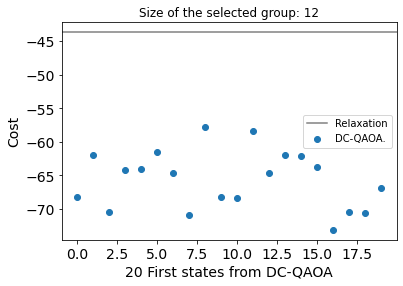

In [78]:
plt.axhline(y=linear.cost_min, linestyle='-',alpha=0.5, c='k',label='Relaxation')
plt.scatter(x=range(len(cost_dc)), y=cost_dc, label="DC-QAOA.")
#plt.plot(qaoa.costs, label='QAOA')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Size of the selected group: %d"%len(G))
plt.xlabel('20 First states from DC-QAOA',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend()